In [45]:
import helper_functions
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

import pickle

# LSTM
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Conv1D, Activation, Conv2D, Flatten
from tensorflow.keras.layers import InputLayer, Dropout, LSTM, BatchNormalization

import helper_functions

from sklearn.metrics import confusion_matrix

import seaborn as sns
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Load Data 


In [46]:
# I am not using the helper function as my path is different (Alex)
data_path = 'data/processed/data'
with open(data_path, 'rb') as f:
    data = pickle.Unpickler(f).load()

In [47]:
# Shuffle the data
dataToShuffle = []

for log, mfcc, label in zip(data['log-mel'],data['mfccs'],data['classes']):
    dataToShuffle.append([log,mfcc,label])

ShuffledData = np.array(dataToShuffle)
np.random.shuffle(ShuffledData)
print(ShuffledData.shape)

(64721, 3)


<ipython-input-47-5e333558eba3>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ShuffledData = np.array(dataToShuffle)


In [48]:
# Separate the data into training and test datasets
Train = ShuffledData[:45305]
Test = ShuffledData[45305:]

log_train = []
mfcc_train = []
y_train = []

log_test = []
mfcc_test = []
y_test = []

for log, mfcc, label in Train:
    log_train.append(log)
    mfcc_train.append(mfcc)
    y_train.append(label)
    
for log, mfcc, label in Test:
    log_test.append(log)
    mfcc_test.append(mfcc)
    y_test.append(label)


# Create the model 


In [53]:
InputShape = log_test[0].shape
output_dim = y_test[0].shape[0]
dropout = 0.2


# Creation of the Convolutional LSTM
CLSTM = Sequential()
# Input layer
CLSTM.add(InputLayer(input_shape = (15,173)))

# First convolutional layer with relu, BatchNorm and dropout
CLSTM.add(Conv1D(filters=256, kernel_size=10, strides=4, name='conv_1'))
CLSTM.add(BatchNormalization())
CLSTM.add(Activation('relu'))

CLSTM.add(Dropout(dropout, name='dropout_1'))

# Two LSTM cells
CLSTM.add(LSTM(128, activation='relu', return_sequences=True,
             dropout=dropout, name='lstm_1'))
CLSTM.add(LSTM(128, activation='relu', dropout= dropout, return_sequences=False, name='lstm_2'))

# Two dense layers with dropout
CLSTM.add(Dense(units=100, name='fc1'))
CLSTM.add(BatchNormalization())
CLSTM.add(Activation('relu'))
#CLSTM.add(Dropout(dropout, name='dropout_2'))

CLSTM.add(Dense(units=output_dim, activation='softmax', name='softmax'))





# Create the optimizer
opt = keras.optimizers.Adam(learning_rate=1e-4)

# Import new metrics 
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()

# Compile the model 
CLSTM.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy', recall, precision])

In [54]:
CLSTM.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 2, 256)            443136    
_________________________________________________________________
batch_normalization_13 (Batc (None, 2, 256)            1024      
_________________________________________________________________
activation_15 (Activation)   (None, 2, 256)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 128)            197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
fc1 (Dense)                  (None, 100)              

In [55]:
plot_model(CLSTM, to_file='model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Train the model 

In [59]:
#Train the model 

# Initiate early stopping callback (on validation set from training data 0.15)
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 3)
# Initiate x and y train arrays
x_train = np.array(mfcc_train)
y_train = np.array(y_train)

# Fit the model on the data 
history = CLSTM.fit(x=x_train, y=y_train, epochs=30, batch_size=128, validation_split = 0.10, callbacks = [callback])

Epoch 1/30
319/319 [==============================] - 8s 24ms/step - loss: 0.3899 - accuracy: 0.8710 - recall_9: 0.8416 - precision_9: 0.9009 - val_loss: 0.3727 - val_accuracy: 0.8755 - val_recall_9: 0.8565 - val_precision_9: 0.9034
Epoch 2/30
319/319 [==============================] - 7s 23ms/step - loss: 0.3846 - accuracy: 0.8733 - recall_9: 0.8429 - precision_9: 0.9023 - val_loss: 0.3707 - val_accuracy: 0.8791 - val_recall_9: 0.8570 - val_precision_9: 0.9039
Epoch 3/30
319/319 [==============================] - 8s 24ms/step - loss: 0.3744 - accuracy: 0.8762 - recall_9: 0.8477 - precision_9: 0.9062 - val_loss: 0.3747 - val_accuracy: 0.8806 - val_recall_9: 0.8588 - val_precision_9: 0.9036
Epoch 4/30
319/319 [==============================] - 8s 24ms/step - loss: 0.3763 - accuracy: 0.8741 - recall_9: 0.8466 - precision_9: 0.9028 - val_loss: 0.3904 - val_accuracy: 0.8718 - val_recall_9: 0.8559 - val_precision_9: 0.8954
Epoch 5/30
319/319 [==============================] - 8s 24ms/step -

# Save the model 

In [187]:
# Save the model 
CLSTM.save('models\ConvLSTM')

# Save history object
file = open('models\ConvLSTM_history', 'wb')
pickle.dump(history.history,file)
file.close()

INFO:tensorflow:Assets written to: models\ConvLSTM\assets


# Load the model

In [44]:
# Load the model 
model = keras.models.load_model('models\ConvLSTM')

model.summary()
# Load the history object 
file = open('models\ConvLSTM_history', 'rb')
history = pickle.load(file)
file.close()


Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 2, 256)            443136    
_________________________________________________________________
batch_normalization_43 (Batc (None, 2, 256)            1024      
_________________________________________________________________
activation_44 (Activation)   (None, 2, 256)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 128)            197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
fc1 (Dense)                  (None, 64)              

# Test the model 

In [61]:
# Testing the model 

#Evaluate function 
x_test = np.array(mfcc_test)
y_test = np.array(y_test)
score = model.evaluate(x_test,y_test)

607/607 [==============================] - 2s 3ms/step - loss: 0.3480 - accuracy: 0.8883 - recall_1: 0.8655 - precision_1: 0.9132


In [43]:
# Model's prediction on the test data and the desired output
output = model.predict(x_test)

logits_pred = output.argmax(axis=1)
logits_test = y_test.argmax(axis=1)

print(logits_test)

[ 9  2 11 ...  4 11 11]


# Plotting the results and metrics

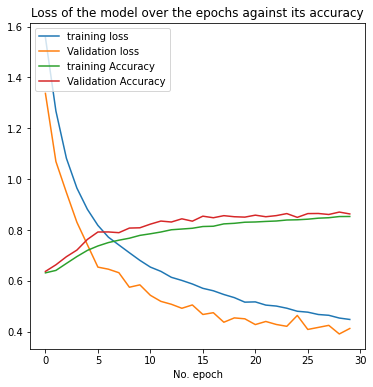

In [241]:
# Training/Validation Loss
plt.figure(figsize = (6,6))
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="Validation loss")
plt.plot(history['accuracy'], label="training Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")
plt.title('Loss of the model over the epochs against its accuracy')

plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

<AxesSubplot:>

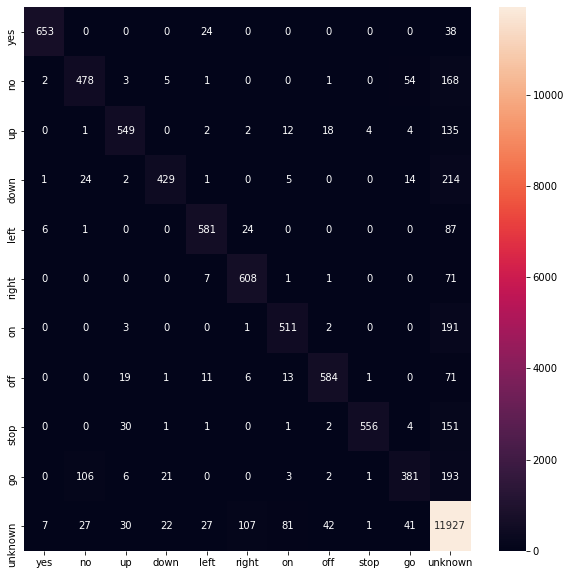

In [237]:
# Confusion matrix
PermitedLabels = ['yes','no','up','down','left','right','on','off','stop','go','unknown']

 
cf_matrix = confusion_matrix(logits_test,logits_pred)

# Plotting the matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels=PermitedLabels, yticklabels=PermitedLabels, ax = ax)

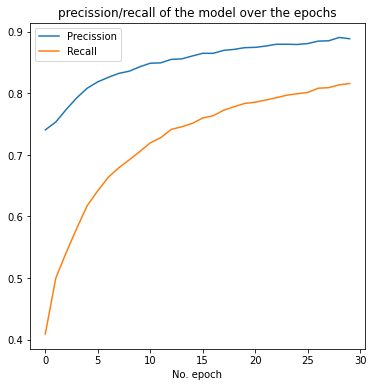

In [242]:
# Precision / Recall curve (training)
plt.figure(figsize = (6,6))
plt.plot(history['precision_1'], label="Precission")
plt.plot(history['recall_1'], label="Recall")
plt.title('precission/recall of the model over the epochs')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()